C:\Users\Admin\AppData\Local\Temp\ipykernel_13408\53559823.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  calc_corr_table = calc_corr_table.append({'Store1': store_comparison, 'Store2': i, 'corr_measure': corr_measure},
C:\Users\Admin\AppData\Local\Temp\ipykernel_13408\53559823.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  calc_corr_table = calc_corr_table.append({'Store1': store_comparison, 'Store2': i, 'corr_measure': corr_measure},
C:\Users\Admin\AppData\Local\Temp\ipykernel_13408\53559823.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  calc_corr_table = calc_corr_table.append({'Store1': store_comparison, 'Store2': i, 'corr_measure': corr_measure},
C:\Users\Admin\AppData\Local\Temp\ipykernel_13408\53559

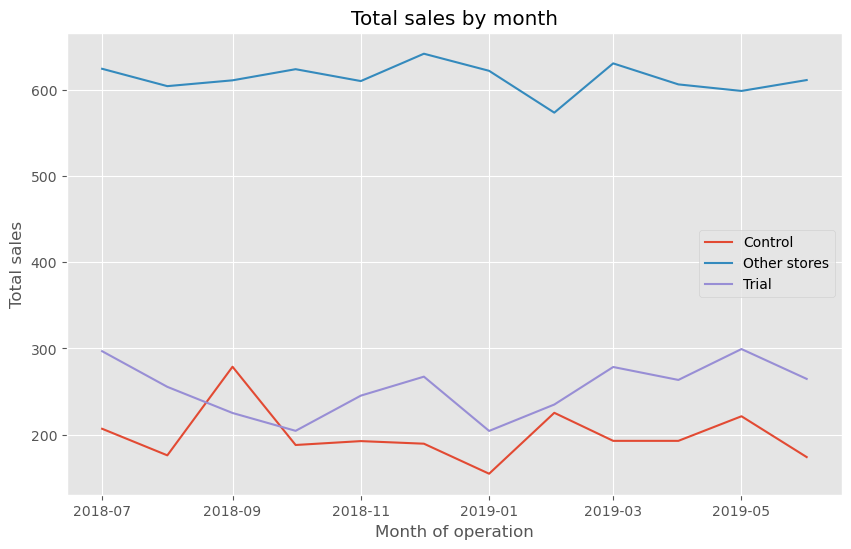

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = "C:/Users/Admin/Downloads/QVI_data.csv"
data = pd.read_csv(file_path)

# Convert DATE column to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Set themes for plots
plt.style.use('ggplot')

# Select control stores
trial_store_numbers = [77, 86, 88]

# Define functions
def calculate_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    store_numbers = input_table['STORE_NBR'].unique()
    for i in store_numbers:
        corr_measure = input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col].corr(
            input_table.loc[input_table['STORE_NBR'] == i, metric_col])
        calc_corr_table = calc_corr_table.append({'Store1': store_comparison, 'Store2': i, 'corr_measure': corr_measure},
                                                 ignore_index=True)
    return calc_corr_table

def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
    store_numbers = input_table['STORE_NBR'].unique()
    for i in store_numbers:
        measure = np.abs(input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col].values[0] - 
                         input_table.loc[input_table['STORE_NBR'] == i, metric_col].values[0])
        calc_dist_table = calc_dist_table.append({'Store1': store_comparison, 'Store2': i, 'YEARMONTH': input_table.loc[
            input_table['STORE_NBR'] == store_comparison, 'YEARMONTH'].values[0], 'measure': measure}, ignore_index=True)
    
    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
    dist_table['magnitude_measure'] = 1 - (dist_table['measure'] - dist_table['min']) / (dist_table['max'] - dist_table['min'])
    final_dist_table = dist_table.groupby(['Store1', 'Store2'])['magnitude_measure'].mean().reset_index()
    
    return final_dist_table

# Calculate measures over time for each store
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / x.nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / x.nunique())
).reset_index()

# Calculate average price per unit
measure_over_time['avgPricePerUnit'] = measure_over_time['totSales'] / data.groupby(['STORE_NBR', 'YEARMONTH'])['PROD_QTY'].sum().reset_index()['PROD_QTY']


# Filter to pre-trial period and stores with full observation periods
stores_with_full_obs = measure_over_time.groupby('STORE_NBR').size().loc[lambda x: x == 12].index
pre_trial_measures = measure_over_time[(measure_over_time['YEARMONTH'] < 201902) &
                                       (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))]

# Calculate correlation and magnitude distance
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store_numbers[0])
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store_numbers[0])

magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store_numbers[0])
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store_numbers[0])

# Combine scores
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['magnitude_measure'] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['magnitude_measure'] * (1 - corr_weight)

score_Control = pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']], 
                         score_nCustomers[['Store1', 'Store2', 'scoreNCust']], on=['Store1', 'Store2'])
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Select control store
control_store = score_Control[score_Control['Store1'] == trial_store_numbers[0]].sort_values(by='finalControlScore', ascending=False).iloc[1]['Store2']

# Visual checks on trends based on the drivers
measure_over_time_sales = measure_over_time[['STORE_NBR', 'YEARMONTH', 'totSales']].copy()
measure_over_time_sales['Store_type'] = np.where(measure_over_time_sales['STORE_NBR'] == trial_store_numbers[0], 'Trial',
                                                 np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores'))
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type']).agg({'totSales': 'mean'}).reset_index()
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

plt.figure(figsize=(10, 6))
for store_type in past_sales['Store_type'].unique():
    plt.plot(past_sales.loc[past_sales['Store_type'] == store_type, 'TransactionMonth'], 
             past_sales.loc[past_sales['Store_type'] == store_type, 'totSales'], label=store_type)
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend()
plt.show()


For Trial Store 77, the Control Store is 1.0


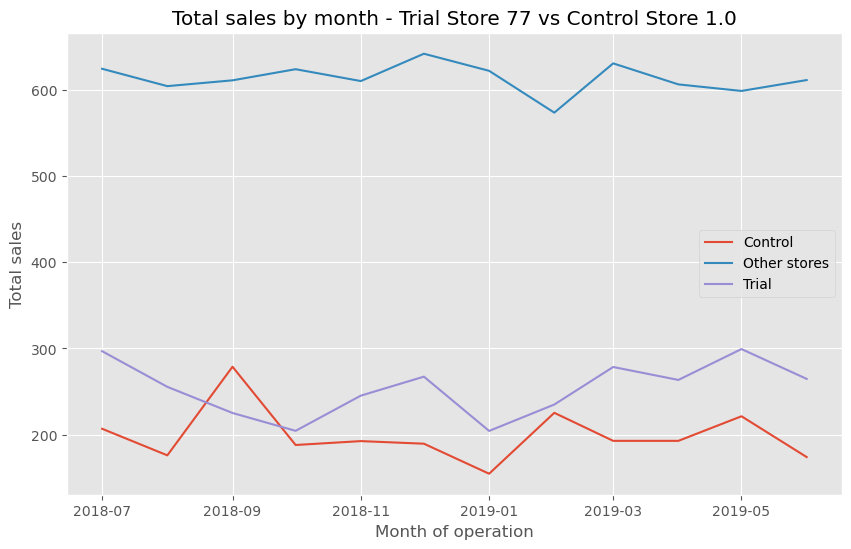

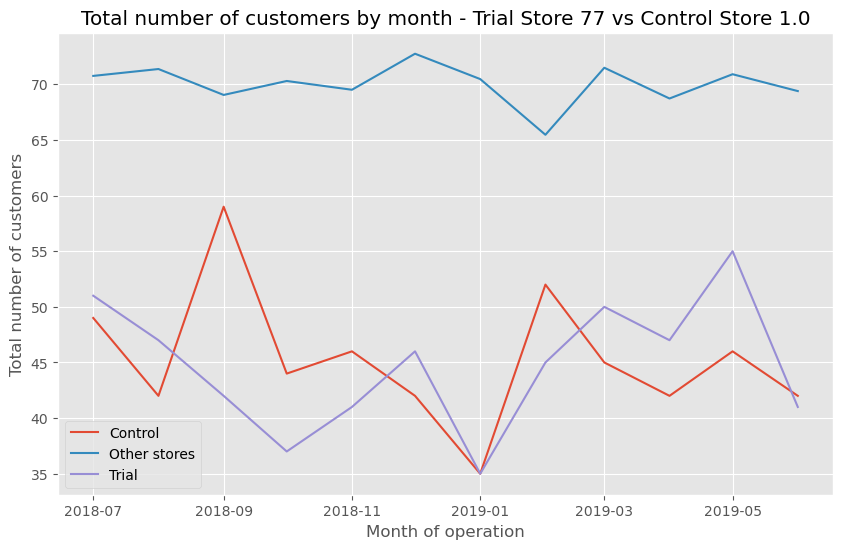

IndexError: single positional indexer is out-of-bounds

In [7]:
# Loop through each trial store
for trial_store in trial_store_numbers:
    # Calculate the control store for the current trial store
    control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False).iloc[1]['Store2']
    
    print(f"For Trial Store {trial_store}, the Control Store is {control_store}")
    
    # Plot total sales by month for current trial and control stores
    measure_over_time_sales = measure_over_time[['STORE_NBR', 'YEARMONTH', 'totSales']].copy()
    measure_over_time_sales['Store_type'] = np.where(measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
                                                     np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores'))
    past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type']).agg({'totSales': 'mean'}).reset_index()
    past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

    plt.figure(figsize=(10, 6))
    for store_type in past_sales['Store_type'].unique():
        plt.plot(past_sales.loc[past_sales['Store_type'] == store_type, 'TransactionMonth'], 
                 past_sales.loc[past_sales['Store_type'] == store_type, 'totSales'], label=store_type)
    plt.xlabel('Month of operation')
    plt.ylabel('Total sales')
    plt.title(f'Total sales by month - Trial Store {trial_store} vs Control Store {control_store}')
    plt.legend()
    plt.show()  

    # Plot total number of customers by month for current trial and control stores
    measure_over_time_customers = measure_over_time[['STORE_NBR', 'YEARMONTH', 'nCustomers']].copy()
    measure_over_time_customers['Store_type'] = np.where(measure_over_time_customers['STORE_NBR'] == trial_store, 'Trial',
                                                     np.where(measure_over_time_customers['STORE_NBR'] == control_store, 'Control', 'Other stores'))
    past_customers = measure_over_time_customers.groupby(['YEARMONTH', 'Store_type']).agg({'nCustomers': 'mean'}).reset_index()
    past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')

    plt.figure(figsize=(10, 6))
    for store_type in past_customers['Store_type'].unique():
        plt.plot(past_customers.loc[past_customers['Store_type'] == store_type, 'TransactionMonth'], 
                 past_customers.loc[past_customers['Store_type'] == store_type, 'nCustomers'], label=store_type)
    plt.xlabel('Month of operation')
    plt.ylabel('Total number of customers')
    plt.title(f'Total number of customers by month - Trial Store {trial_store} vs Control Store {control_store}')
    plt.legend()
    plt.show()
